# Stability anaylsis with ERA5 Ensembles

## Preliminaries
### Data boundaries
- conforming to pv anomaly detection:
- calculate climatology and set boundaries
- file at  /daten/weclip/work/blocks_era5/BLOCKS1979_2019_1.3
- **Use gh index (freva) bc. we use gh for analysis instead of pv?
- Or use pv for stability analysis instead?

**Boundaries:**
- 1979 - 2019 (extend?)


In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
from matplotlib.patches import Rectangle
from scipy.signal import detrend

f_path = "/daten/weclip/work/blocks_era5/BLOCKS1979_2019_1.3"
d_path = "../data/"

# Define the lat-lon box bounds
lon_min, lon_max = -100, 20  # Longitude range
lat_min, lat_max = 20, 90    # Latitude range

### Set up dask

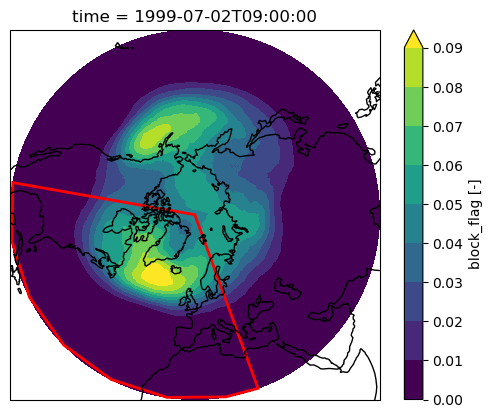

In [10]:
block_mean = xr.open_dataset(d_path + "BLOCKFLAGMEAN.nc")
p = block_mean.isel(time=0).sel(latitude=slice(20, 90))["FLAG"].plot.contourf(
    levels=np.arange(0, 0.1, 0.01), subplot_kws=dict(
        projection=ccrs.Stereographic(central_latitude=90.0, true_scale_latitude=50.0,
                                      central_longitude=0)), transform=ccrs.PlateCarree())
p.axes.coastlines()

# Create a rectangle for the box
box = Rectangle(
    (lon_min, lat_min),           # Bottom-left corner (lon, lat)
    lon_max - lon_min,            # Width (delta longitude)
    lat_max - lat_min,            # Height (delta latitude)
    linewidth=2,                  # Line thickness
    edgecolor='red',              # Border color
    facecolor='none',             # No fill
    transform=ccrs.PlateCarree()  # Ensure it aligns with map projection
)

# Add the box to the map
p.axes.add_patch(box)

## Calculate EOFs
- Calculate EOFs from ERA5 reanalysis data (to be used also for the ensemble members)
### Preprocessing
- 1950-2023

In [ ]:
ERA5_DIR = ("/daten/reana/arch/reanalysis/reanalysis/DKRZ/IFS/" +
            "ERA5/day/atmos/zg/r1i1p1-050000Pa/")
files = [ERA5_DIR + f"zg_day_reanalysis_era5_r1i1p1-050000Pa_{y}0101-{y}1231.nc"
         for y in range(1950, 1958)]
# bc we have 427 lon and 249 lat
chunkdict = {'time': -1, 'lat': 50, 'lon': 60}

#### Climatology

In [7]:
ds = xr.open_mfdataset(files, parallel=True,
                       combine="by_coords")
ds = ds.assign_coords(
    lon=(((ds.lon + 180) % 360) - 180)
)

# Sort the dataset by longitude for proper slicing
ds = ds.sortby('lon')
zg = ds['zg'].sel(lat=slice(lat_min, lat_max),
                  lon=slice(lon_min, lon_max)).chunk(chunkdict)
print(zg.chunks)

zg_climatology = zg.groupby("time.dayofyear").mean(dim="time")
print(zg_climatology.chunks)

zg_climatology.to_netcdf(d_path + "zg_climatology.nc")

((26663,), (50, 50, 50, 50, 49), (60, 60, 60, 60, 60, 60, 60, 7))
((366,), (50, 50, 50, 50, 49), (60, 60, 60, 60, 60, 60, 60, 7))


KeyboardInterrupt: 

In [ ]:
zg_climatology

<xarray.DataArray 'zg' (dayofyear: 366, lat: 249, lon: 427)> Size: 156MB
dask.array<transpose, shape=(366, 249, 427), dtype=float32, chunksize=(366, 83, 61), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB 20.09 20.37 20.66 20.94 ... 89.23 89.51 89.78
    plev       float64 8B 5e+04
  * lon        (lon) float64 3kB -99.84 -99.56 -99.28 ... 19.41 19.69 19.97
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential height
    units:          m
    code:           129
    table:          128
    original_name:  var129

#### Anomalies

In [ ]:
zg_climatology = xr.open_dataset(
    d_path + "zg_climatology.nc", chunks=chunkdict)
zg_anom = zg.groupby("time.dayofyear") - zg_climatology
zg_anom.to_netcdf(d_path + "zg_anom.nc")

#### Detrend

In [ ]:
zg_anom = xr.open_dataset(d_path + "zg_anom.nc",
                          chunks=chunkdict)
print(zg_anom)


def detrend_1d(data):
    # Apply detrend
    return detrend(data, axis=-1)


# Apply the function using apply_ufunc
zg_detrend = xr.apply_ufunc(
    detrend_1d,
    zg_anom,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    dask="parallelized",
    vectorize=True,
    output_dtypes=[float],  # Ensure output dtype is float
    keep_attrs=True
)


print(type(zg_detrend))
zg_detrend = zg_detrend.astype("float32")
# Save the detrended dataset (optional)
zg_detrend.to_netcdf(d_path + "zg_detrend.nc")

<xarray.Dataset> Size: 1GB
Dimensions:    (lat: 249, time: 2922, lon: 427)
Coordinates:
  * lat        (lat) float64 2kB 20.09 20.37 20.66 20.94 ... 89.23 89.51 89.78
    plev       (time) float64 23kB dask.array<chunksize=(2922,), meta=np.ndarray>
  * lon        (lon) float64 3kB -99.84 -99.56 -99.28 ... 19.41 19.69 19.97
    dayofyear  (time) int64 23kB dask.array<chunksize=(2922,), meta=np.ndarray>
  * time       (time) datetime64[ns] 23kB 1950-01-01T12:00:00 ... 1957-12-31T...
Data variables:
    zg         (time, lat, lon) float32 1GB dask.array<chunksize=(2922, 83, 61), meta=np.ndarray>
<class 'xarray.core.dataset.Dataset'>


#### Check whether this works

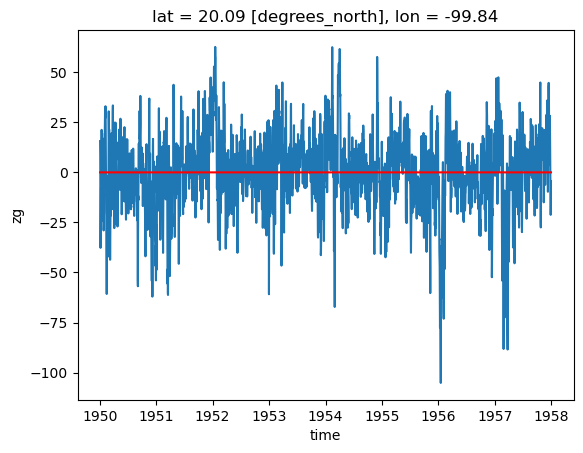

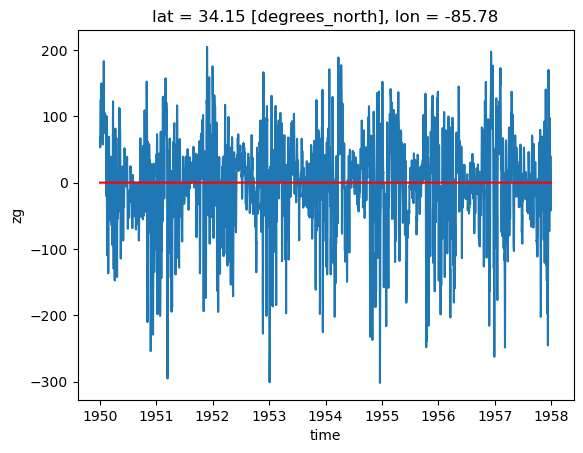

In [ ]:
from scipy.stats import linregress
zg_detrend = xr.open_dataset(d_path + "zg_detrend.nc", chunks=chunkdict)
zg_detrend.isel(lat=0, lon=0)["zg"].plot()
slope, intercept, r_value, p_value, std_err = linregress(
    np.arange(zg_detrend.isel(lat=0, lon=0)["zg"].shape[0]),
    zg_detrend.isel(lat=0, lon=0)["zg"])
regression_line = slope * \
    np.arange(zg_detrend.isel(lat=0, lon=0)["zg"].shape[0]) + intercept
plt.plot(zg_detrend.isel(lat=0, lon=0)["time"],
         regression_line, label='Linear Regression',
         color='red')  # Regression line

plt.figure()
zg_detrend.isel(lat=50, lon=50)["zg"].plot()
slope, intercept, r_value, p_value, std_err = linregress(
    np.arange(zg_detrend.isel(lat=50, lon=50)["zg"].shape[0]),
    zg_detrend.isel(lat=50, lon=50)["zg"])
regression_line = slope * \
    np.arange(zg_detrend.isel(lat=50, lon=50)["zg"].shape[0]) + intercept
plt.plot(zg_detrend.isel(lat=50, lon=50)["time"],
         regression_line, label='Linear Regression',
         color='red')  # Regression line

#### Normalize anomalies by running std

(249,)
<xarray.DataArray (dayofyear: 366)> Size: 3kB
dask.array<truediv, shape=(366,), dtype=float64, chunksize=(351,), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366


/home/schoelleh96/mambaforge/envs/wp22a/lib/python3.12/site-packages/dask/array/core.py:5028: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


xarray.Dataset {
dimensions:
	lat = 249 ;
	time = 2922 ;
	lon = 427 ;

variables:
	float64 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:axis = Y ;
		lat:bounds = lat_bnds ;
	float64 plev(time) ;
		plev:standard_name = air_pressure ;
		plev:long_name = pressure ;
		plev:units = Pa ;
		plev:positive = down ;
		plev:axis = Z ;
	float64 lon(lon) ;
	int64 dayofyear(time) ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:axis = T ;
	float64 zg(lat, lon, time) ;

// global attributes:
}

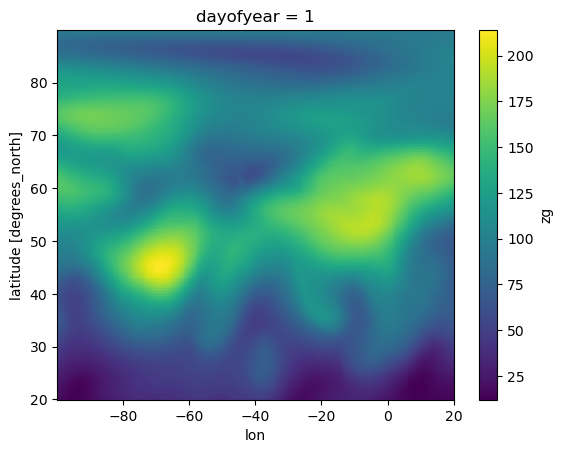

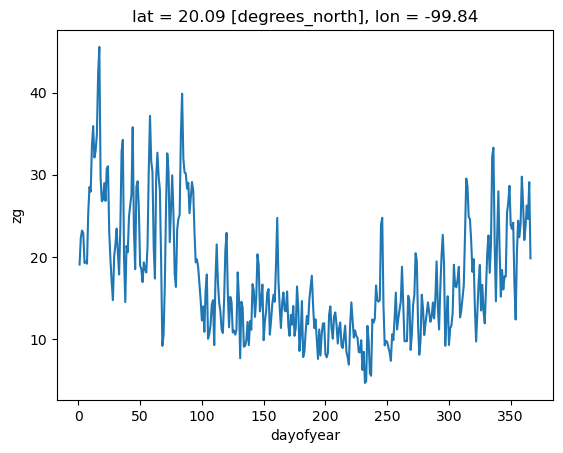

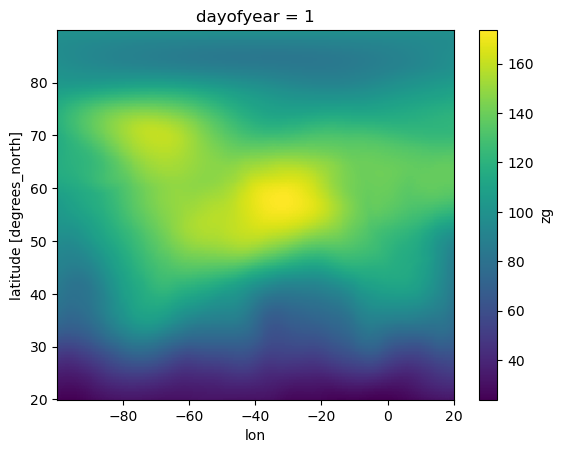

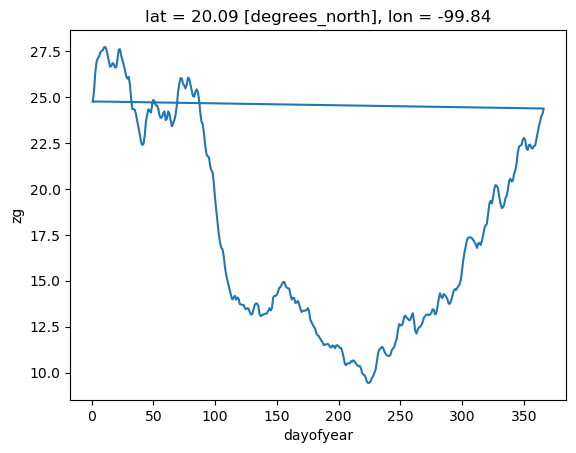

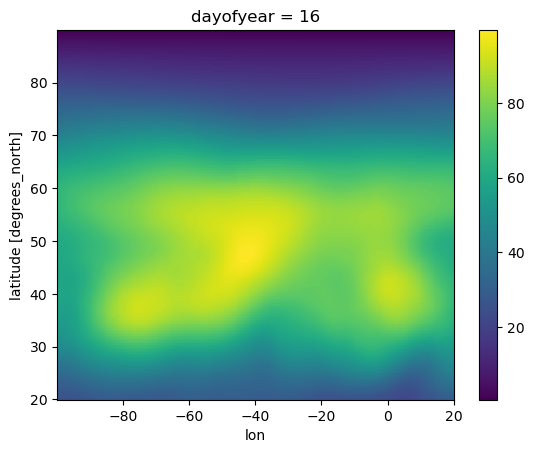

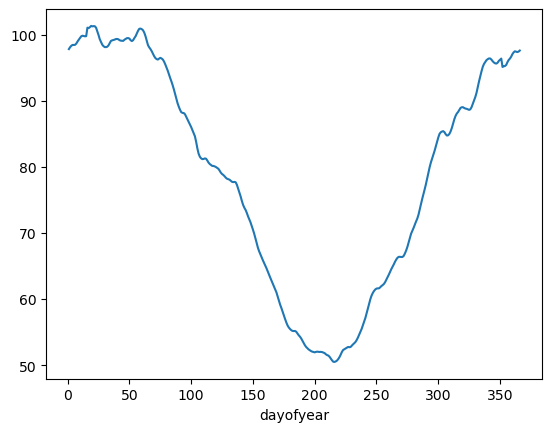

In [ ]:
def normalize_data(data, variable, window):
    std_day = (
        data[variable].groupby("time.dayofyear")
        .std(dim="time")
    )
    std_day.isel(dayofyear=0).plot()
    plt.figure()

    std_day.isel(lat=0, lon=0).plot()

    extended = xr.concat(
        [std_day.isel(dayofyear=slice(-int(np.ceil(window/2)), None)), std_day,
         std_day.isel(dayofyear=slice(None, int(np.ceil(window/2))))], dim="dayofyear"
    )

    roll_std = extended.rolling(dayofyear=window, center=True).mean()
    plt.figure()

    roll_std.isel(dayofyear=int(np.ceil(window/2))).plot()
    plt.figure()

    roll_std.isel(lat=0, lon=0).plot()

    cos_lat = np.cos(np.deg2rad(roll_std.lat))

    plt.figure()

    (roll_std.isel(dayofyear=slice(15, 366+15)) *
     cos_lat).isel(dayofyear=int(np.ceil(window/2))).plot()

    mean_std = ((
        roll_std.isel(dayofyear=slice(15, 366+15)) * cos_lat)
        .mean(dim=['lat', 'lon']) / cos_lat.mean()
    )
    print(mean_std)
    plt.figure()

    mean_std.plot()

    return data.groupby("time.dayofyear") / mean_std


zg_norm = normalize_data(zg_detrend, "zg", window=30)
zg_norm.info()
zg_norm.to_netcdf(d_path + "zg_norm.nc")

### Perform EOF
Need to use different mamba env for this (eof_env)

In [ ]:
import xarray as xr
import xeofs as xe

d_path = "../data/"
chunkdict = {'time': -1, 'lat': 83, 'lon': 61}

# Open the dataset (already preprocessed)
zg_norm = xr.open_dataset(d_path + 'zg_norm.nc')['zg']

# Ensure data is chunked along time (Dask-friendly)
zg_norm = zg_norm.chunk(chunkdict)

# Instantiate the EOF solver with 50 EOFs
solver = xe.single.EOF(n_modes=50, use_coslat=True)

# Fit the solver (computes EOFs)
solver.fit(zg_norm, "time")

# Access the EOFs and PCs
eofs = solver.components()  # EOF spatial patterns
pcs = solver.scores()    # Principal components
ev = solver.explained_variance_ratio()

eofs.attrs.pop("solver_kwargs", None)
pcs.attrs.pop("solver_kwargs", None)
ev.attrs.pop("solver_kwargs", None)

eofs.to_netcdf(d_path + 'eofs.nc')
pcs.to_netcdf(d_path + 'pcs.nc')
ev.to_netcdf(d_path + 'evals.nc')

### Back to old env from here

In [6]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

In [7]:
sys.path.append(os.path.abspath(os.path.join('..', 'pyscripts')))

In [8]:
from data_classes import DataHandler
import data_classes
import utils as ut
d_path = "../data/"

In [ ]:
EOFs = DataHandler(d_path + "eofs.nc")
PCs = DataHandler(d_path + "pcs.nc")
Evals = DataHandler(d_path + "evals.nc")
Evals.load_data()
EOFs.load_data()
PCs.load_data()

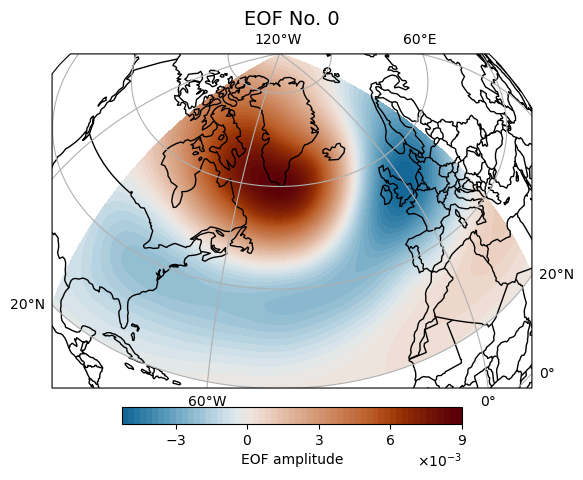

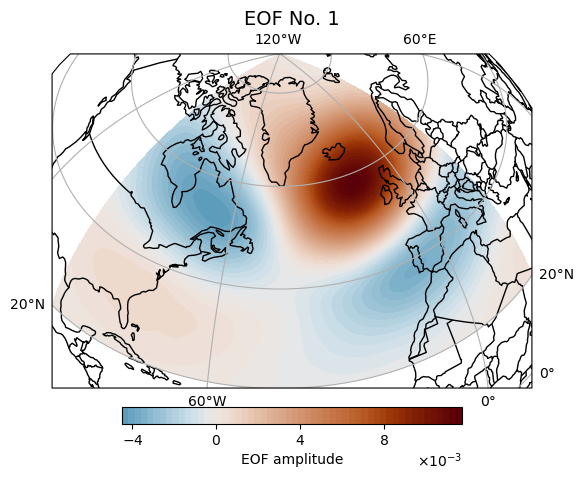

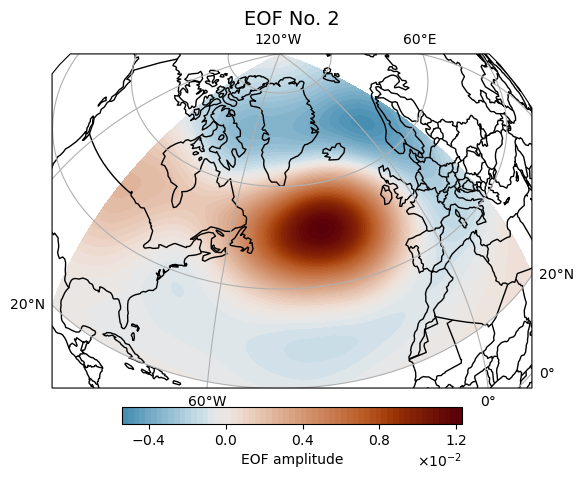

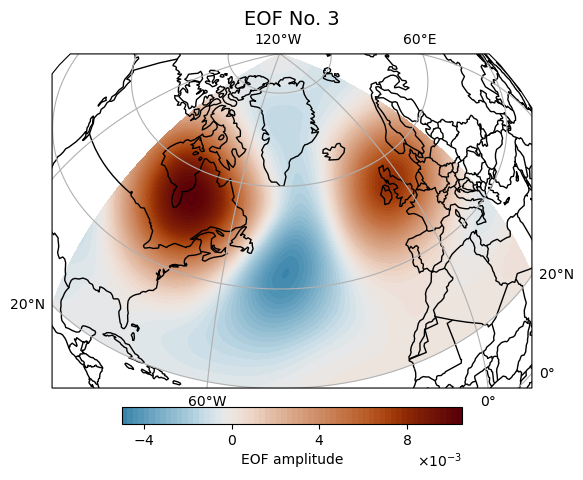

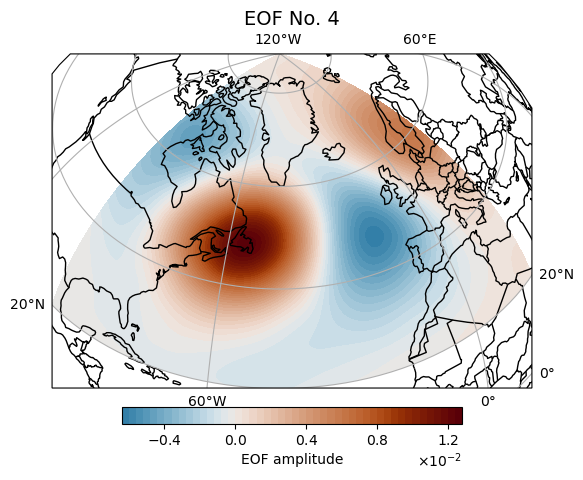

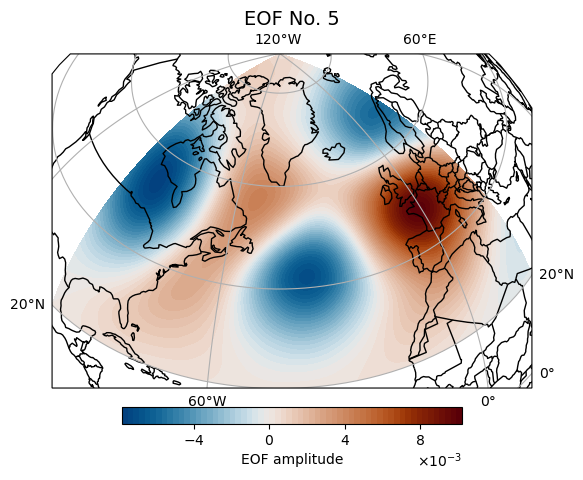

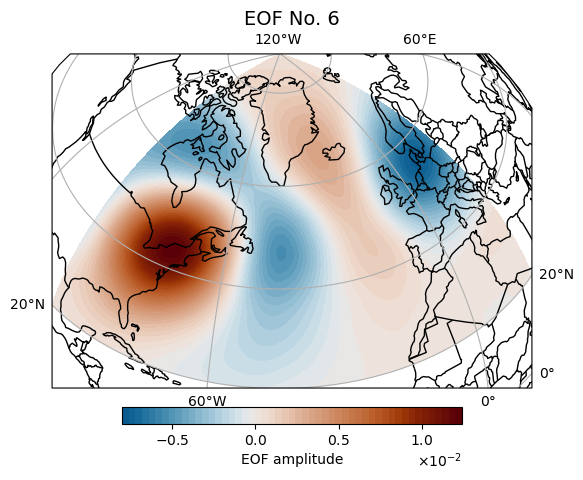

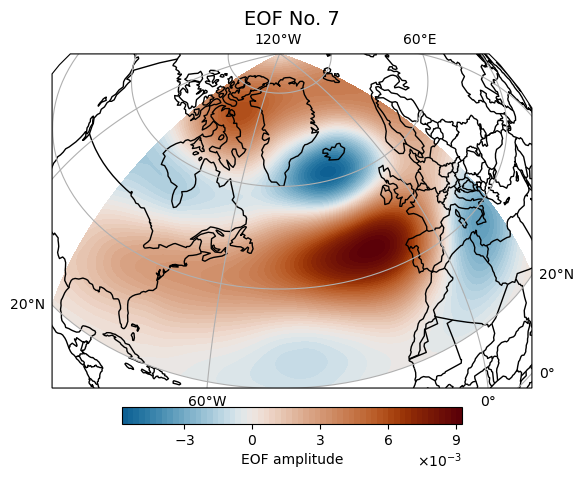

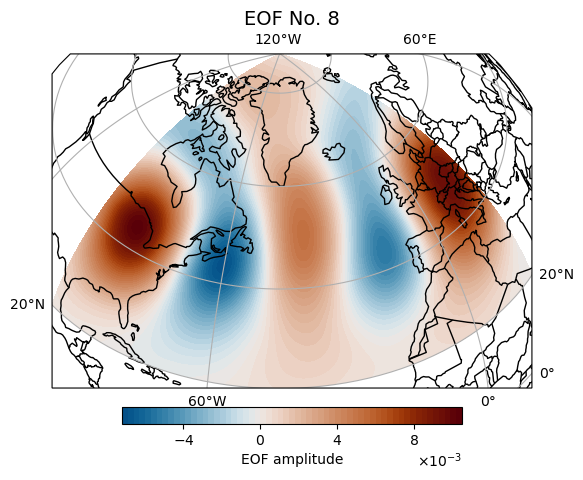

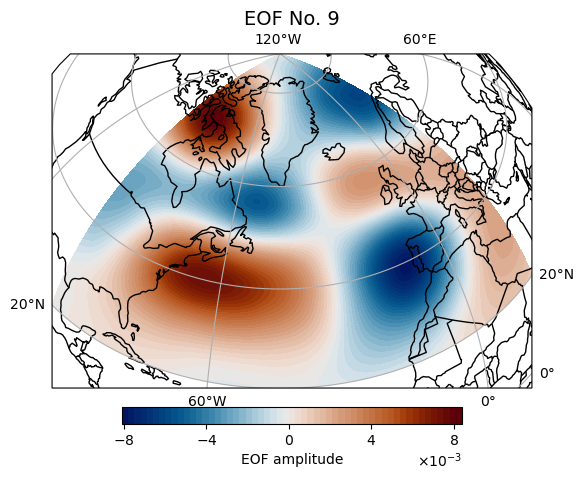

In [ ]:
for i in range(10):
    EOFs.plot(EOFs.dataset.isel(mode=i)["components"], "EOF amplitude",
              "EOF No. {}".format(i))

In [ ]:
pc_std = []
for i in range(50):
    pc_std.append(PCs.dataset["scores"][i, :].std())
pc_std.sort(reverse=True)
pc_std = np.array(pc_std)**2
pc_std = pc_std / pc_std.sum() * \
    Evals.dataset["explained_variance_ratio"].values.flatten().sum()

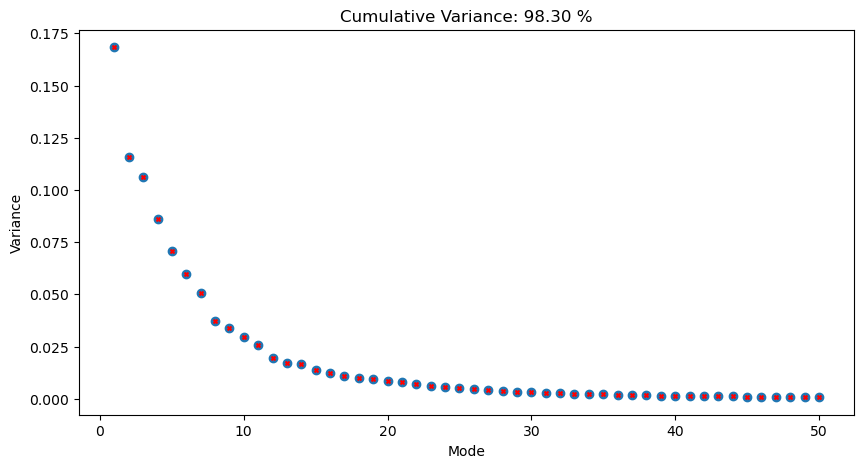

In [ ]:
var_ratio = Evals.dataset["explained_variance_ratio"].values.flatten()[
    :50].sum() * 100
# plot more eigenvalues
# Plot the first 10 eigenvalues (for example)
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(np.arange(1, 51),
           Evals.dataset["explained_variance_ratio"].values.flatten()[:50])
plt.xlabel("Mode")
plt.ylabel("Variance")
plt.title("Cumulative Variance: {:.2f} %".format(var_ratio))
ax.scatter(np.arange(1, 51), pc_std, marker="x", color="red", s=8)
plt.show()

## Now use the ERA5 Ensembles

In [2]:
ens_ds = xr.load_dataset("../ens_data/test_ens.grib", engine="cfgrib")

<xarray.Dataset> Size: 4GB
Dimensions:        (number: 10, time: 365, latitude: 361, longitude: 720)
Coordinates:
  * number         (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * time           (time) datetime64[ns] 3kB 1950-01-01T12:00:00 ... 1950-12-...
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 500.0
  * latitude       (latitude) float64 3kB 90.0 89.5 89.0 ... -89.0 -89.5 -90.0
  * longitude      (longitude) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
    valid_time     (time) datetime64[ns] 3kB 1950-01-01T12:00:00 ... 1950-12-...
Data variables:
    z              (number, time, latitude, longitude) float32 4GB 5.133e+04 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:          

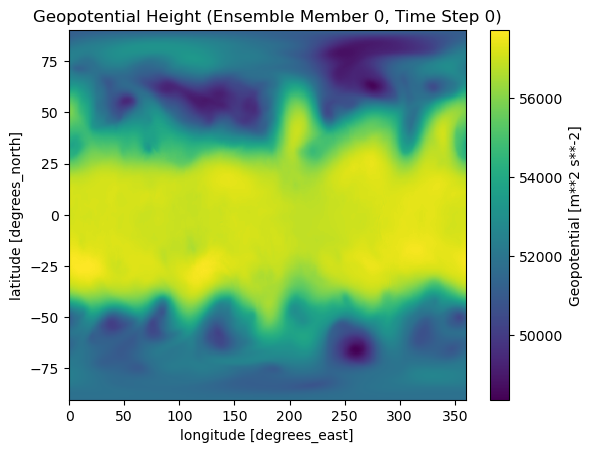

In [3]:
# Print the dataset summary
print(ens_ds)

# Print the dimensions
print("\nDimensions:")
print(ens_ds.dims)

# Print the coordinates
print("\nCoordinates:")
print(ens_ds.coords)

# Print the data variables
print("\nData Variables:")
print(ens_ds.data_vars)

# Plot a sample of the data (e.g., the first ensemble member at the first time step)
ens_ds.isel(number=0, time=0)["z"].plot()
plt.title("Geopotential Height (Ensemble Member 0, Time Step 0)")
plt.show()

### Is member 0 the control? Write a mail

In [9]:
EOFs = DataHandler(d_path + "eofs.nc")
EOFs.load_data()
EOFs.dataset.info()

xarray.Dataset {
dimensions:
	lat = 249 ;
	lon = 427 ;
	mode = 50 ;

variables:
	float64 lat(lat) ;
	float64 lon(lon) ;
	int64 mode(mode) ;
	float64 components(mode, lat, lon) ;
		components:model = EOF analysis ;
		components:software = xeofs ;
		components:version = 3.0.4 ;
		components:date = 2024-11-22 11:42:41 ;
		components:n_modes = 50 ;
		components:center = True ;
		components:standardize = False ;
		components:use_coslat = True ;
		components:check_nans = True ;
		components:sample_name = sample ;
		components:feature_name = feature ;
		components:random_state = None ;
		components:compute = True ;
		components:solver = auto ;

// global attributes:
}